<a href="https://colab.research.google.com/github/NLinh-Tran/Lending-Club-Analysis/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
wordsforthewise_lending_club_path = kagglehub.dataset_download('wordsforthewise/lending-club')

print('Data source import complete.')


Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


# **INSTALL PYSPARK**

In [ ]:
!pip install PySpark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import logging
import sys
import os
import plotly.express as px

print('Import Libraries')

Import Libraries


In [ ]:
spark = SparkSession.builder                                        \
                    .appName("LendingClubAnalysis")                 \
                    .config("spark.ui.showConsoleProgress","false") \
                    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [ ]:
accepted_df = spark.read.option("header", True)                                             \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")

rejected_df = spark.read.option("header", True)                                            \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz")

# **Overview**

In [ ]:
print("Accepted Count:", accepted_df.count())
print("Rejected Count:", rejected_df.count())

Accepted Count: 2260701
Rejected Count: 27648741


## Timeframe

In [ ]:
accepted_df.withColumn('issue_date', to_date(col('issue_d'), 'MMM-yyyy')) \
           .select(
                date_format(min('issue_date'), 'MMM-yyyy').alias('Earliest Issue Date'),
                date_format(max('issue_date'), 'MMM-yyyy').alias('Latest Issue Date')
            ).toPandas()

,Earliest Issue Date,Latest Issue Date
0,Jun-2007,Dec-2018


In [ ]:
rejected_df.agg(
                min(col('Application Date')).alias('Earliest Application Date'),
                max(col('Application Date')).alias('Latest Application Date')
                )\
           .toPandas()

,Earliest Application Date,Latest Application Date
0,2007-05-26,2018-12-31


## Schema

In [ ]:
rejected_df.printSchema()

root
 |-- Amount Requested: double (nullable = true)
 |-- Application Date: date (nullable = true)
 |-- Loan Title: string (nullable = true)
 |-- Risk_Score: double (nullable = true)
 |-- Debt-To-Income Ratio: string (nullable = true)
 |-- Zip Code: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Employment Length: string (nullable = true)
 |-- Policy Code: double (nullable = true)



# **COMBINED DATASET**
#### **accepted_df**
* loan_amnt
* emp_length
* dti
* addr_state
* policy_code
* accepted_flag

#### **rejected_df**
* Amount Requested
* Employment Length
* Debt-To-Income-Ratio
* State
* Policy Code
* accepted_flag

In [ ]:
# Accpeted
accepted_c = accepted_df.withColumn('accepted_flag', lit(1)) \
                         .select('loan_amnt', 'emp_length', 'dti', 'addr_state', 'policy_code', 'accepted_flag')

# Rejected
rejected_c = rejected_df.withColumnRenamed('Amount Requested', 'loan_amnt') \
                         .withColumnRenamed('Employment Length', 'emp_length') \
                         .withColumnRenamed('State', 'addr_state') \
                         .withColumnRenamed('Policy Code', 'policy_code') \
                         .withColumn('dti', regexp_replace(col('Debt-To-Income Ratio'), '%', '').cast('double')) \
                         .withColumn('accepted_flag', lit(0)) \
                         .select('loan_amnt', 'emp_length', 'dti', 'addr_state', 'policy_code', 'accepted_flag')

In [ ]:
# Combine 2 datsets
combined_df = accepted_c.union(rejected_c)

combined_df = combined_df.withColumn('emp_length_years',
                                      when(col('emp_length') == '< 1 year', 0)
                                      .when(col('emp_length') == '1 year', 1)
                                      .when(col('emp_length') == '2 years', 2)
                                      .when(col('emp_length') == '3 years', 3)
                                      .when(col('emp_length') == '4 years', 4)
                                      .when(col('emp_length') == '5 years', 5)
                                      .when(col('emp_length') == '6 years', 6)
                                      .when(col('emp_length') == '7 years', 7)
                                      .when(col('emp_length') == '8 years', 8)
                                      .when(col('emp_length') == '9 years', 9)
                                      .when(col('emp_length') == '10+ years', 10)
                                      .when(col('emp_length').isNull(), -1)
                                      .otherwise(-1))
                          # .filter((col('dti') >= 0) & (col('dti') <= 100))

combined_df = combined_df.drop('emp_length')

In [ ]:
combined_df.count()

29909442

## Handle Null Values

In [ ]:
# from pyspark.sql.functions import col, sum as spark_sum
# combined_df.select([
#     spark_sum(col(c).isNull().cast("int")).alias(c)
#     for c in combined_df.columns
# ]).toPandas()

,loan_amnt,dti,addr_state,policy_code,accepted_flag,emp_length_years
0,33,1744,55,951,0,0


Remove all NULL 'loan_amnt' and 'dti' values

In [ ]:
from pyspark.sql.functions import col, sum as spark_sum

combined_df.dropna(subset=['loan_amnt', 'dti']) \
           .select([
                    spark_sum(col(c).isNull().cast("int")).alias(c)
                    for c in combined_df.columns
                  ]).toPandas()

,loan_amnt,dti,addr_state,policy_code,accepted_flag,emp_length_years
0,0,0,22,918,0,0


In [ ]:
combined_df = combined_df.dropna(subset = ['loan_amnt', 'dti']) \
                        .fillna('unknown', subset = ['addr_state'])

combined_df.count()

29907698

## Data leakage

**accepted loans** - policy_code = 1

**rejected loans** - policy_code = 0 | 2| null

This is a shortcut for the model to classify loans. The model will not truyly learn meaningful patterns during training, which would lead to artificially high performance - 100% accuracy

In [ ]:
combined_df.groupBy('policy_code', 'accepted_flag').count().toPandas()

,policy_code,accepted_flag,count
0,1.0,1,2258957
1,2.0,0,88129
2,0.0,0,27559694
3,NaN,0,918


**addr_state**

Due to the imbalanced datasets, where over 90% of applications are rejected, the model relied heavily on geographic patterns to make decision, instead of meaningful financial attributes or behavioral indicators

In [ ]:
accept = combined_df.filter(col('accepted_flag') == 1) \
                    .groupBy('addr_state', 'accepted_flag').count() \
                    .withColumnRenamed('count', 'accept')

reject = combined_df.filter(col('accepted_flag') == 0) \
                    .groupBy('addr_state', 'accepted_flag').count() \
                    .withColumnRenamed('count', 'reject')

total = combined_df.groupBy('addr_state').count() \
                   .withColumnRenamed('count', 'total')

dist = reject.join(accept, 'addr_state', 'left') \
             .join(total, 'addr_state', 'left') \
             .withColumn('acceptance_rate', round((col('accept') / col('total')) * 100, 2)) \
             .withColumn('rejection_rate', round((col('reject') / col('total')) * 100, 2)) \
             .drop('accepted_flag') \
             .select('addr_state', 'total', 'accept', 'acceptance_rate', 'reject', 'rejection_rate') \
             .orderBy('acceptance_rate') \
             .toPandas()
dist

,addr_state,total,accept,acceptance_rate,reject,rejection_rate
0,unknown,22,NaN,NaN,22,100.00
1,IA,470,14.0,2.98,456,97.02
2,MS,289953,12632.0,4.36,277321,95.64
3,ID,84546,4294.0,5.08,80252,94.92
4,AL,520490,27264.0,5.24,493226,94.76
5,AR,308291,17054.0,5.53,291237,94.47
6,SC,496365,27984.0,5.64,468381,94.36
7,LA,447371,25737.0,5.75,421634,94.25
8,TN,611464,35445.0,5.80,576019,94.20
9,KY,371925,21870.0,5.88,350055,94.12


# combined_df without 'policy_code' & 'addr_state'

In [ ]:
combined_df = combined_df.drop('policy_code', 'addr_state')
combined_df.printSchema()

root
 |-- loan_amnt: double (nullable = true)
 |-- dti: double (nullable = true)
 |-- accepted_flag: integer (nullable = false)
 |-- emp_length_years: integer (nullable = false)



## Feature Scaling

### DTI

In [ ]:
combined_df.select('dti').summary().toPandas()

,summary,dti
0,count,29907698
1,mean,133.93524948045496
2,stddev,10133.387168685706
3,min,-1.0
4,25%,8.56
5,50%,19.68
6,75%,35.11
7,max,5.000003149E7


In [ ]:
# Define custom bin ranges for DTI (0 to 100 in steps of 5)
dti_hist = combined_df.select("dti").rdd.flatMap(lambda x: x).histogram([i for i in range(0, 105, 5)])

# Unpack bins and counts
dti_bins = dti_hist[0]
dti_counts = dti_hist[1]

# Calculate midpoints for x-axis labels
dti_midpoints = [(dti_bins[i] + dti_bins[i+1]) / 2 for i in range(len(dti_bins) - 1)]

# Create DataFrame
import pandas as pd
dti_df_hist = pd.DataFrame({
    "DTI": dti_midpoints,
    "Loan Count": dti_counts
})

import plotly.express as px

fig = px.bar(
    dti_df_hist,
    x="DTI",
    y="Loan Count",
    title="DTI Distribution",
    labels={"Loan Count": "Number of Loans"},
    height=400
)

fig.update_layout(
    xaxis_title='',
    yaxis_title='',
    template='simple_white'
)

fig.show()

## loan_amnt

In [ ]:
combined_df.select("loan_amnt").summary().toPandas()

,summary,loan_amnt
0,count,29907698
1,mean,13277.551235589246
2,stddev,14659.60921972099
3,min,0.0
4,25%,5000.0
5,50%,10000.0
6,75%,20000.0
7,max,1400000.0


In [ ]:
# histogram
hist = combined_df.select("loan_amnt").rdd.flatMap(lambda x: x).histogram([i for i in range(0, 1500000, 5000)])

# bins and counts
bins = hist[0]
counts = hist[1]

# Create mid-points for bar chart x-axis
mid_points = [(bins[i] + bins[i+1]) // 2 for i in range(len(bins)-1)]

import pandas as pd
df_hist = pd.DataFrame({
    "Loan Amount": mid_points,
    "Loan Count": counts
})

# bins and counts
bins = hist[0]
counts = hist[1]

# Create mid-points for bar chart x-axis
mid_points = [(bins[i] + bins[i+1]) // 2 for i in range(len(bins)-1)]

import pandas as pd
df_hist = pd.DataFrame({
    "Loan Amount": mid_points,
    "Loan Count": counts
})

import plotly.express as px

fig = px.bar(df_hist, x="Loan Amount", y="Loan Count",
             title="Loan Amount Distribution",
             height=400)

fig.update_layout(
    xaxis_title='',
    yaxis_title='',
    template='simple_white',
    yaxis_type='log'
)

fig.show()

# **ASSEMBLE FEATURES**

* features: contains a single vector of all features per row
* label: the outcome trying to predict

In [ ]:
from pyspark.ml.feature import VectorAssembler

feature_cols = ["loan_amnt", "dti", "emp_length_years"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# **TRAIN LOAN ACCEPTANCE MODEL**
Logistic Regression Model

In [ ]:
# Split into Train and Test Set (80:20)
train_df, test_df = combined_df.randomSplit([0.8, 0.2], seed=42)

from pyspark.ml.classification import LogisticRegression

# Transform both sets so they contain 'features'
train_assembled = assembler.transform(train_df)
test_assembled = assembler.transform(test_df)

# Train the model
lr = LogisticRegression(featuresCol="features", labelCol="accepted_flag")
model = lr.fit(train_assembled)

# **EVALUATIONS**

## Classification Report & Confusion Matrix

              precision    recall  f1-score   support

    Rejected       0.95      0.98      0.96   5127930
    Accepted       0.65      0.38      0.48    451441

    accuracy                           0.93   5579371
   macro avg       0.80      0.68      0.72   5579371
weighted avg       0.92      0.93      0.93   5579371



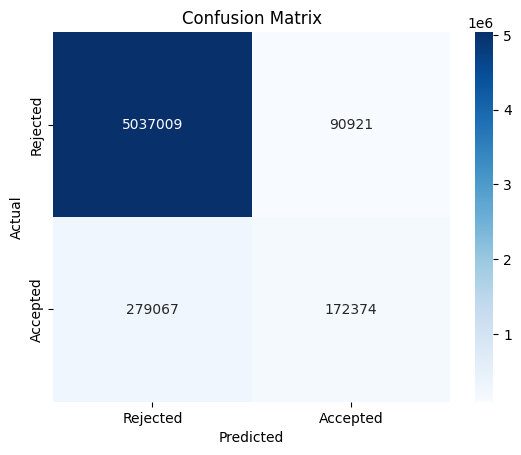

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert prediction results
predictions = model.transform(test_assembled)
preds_pd = predictions.select("accepted_flag", "prediction").toPandas()
print(classification_report(preds_pd["accepted_flag"], preds_pd["prediction"], target_names=["Rejected", "Accepted"]))

# Visualize Confusion Matrix
cm = confusion_matrix(preds_pd["accepted_flag"], preds_pd["prediction"])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Rejected", "Accepted"], yticklabels=["Rejected", "Accepted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## AUC

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="accepted_flag")
print("AUC:", evaluator.evaluate(predictions))

AUC: 0.8644822196857993


# **FEATURE IMPORTANCE**

## **Coefficients**

### **NOTES**:
* **emp_length_years** - the most influential and positively associated with approval - the longer of employment, the more likely loans are to be accepted
* **dti** - minor negative influence - the higher the DTI, the lower probability of being accepted
* **loan_amnt** - almost no impact

### **NOTE**
**emp_length_years** is way more important than **dti** --> not really make sense

In [ ]:
coeffs = model.coefficients.toArray()
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": coeffs
})
coef_df["abs_coefficient"] = np.abs(coef_df["coefficient"])
coef_df_sorted = coef_df.sort_values("abs_coefficient", ascending=False)
coef_df_sorted

,feature,coefficient,abs_coefficient
2,emp_length_years,0.416405,0.416405
1,dti,-0.017949,0.017949
0,loan_amnt,0.000019,0.000019


### **DTI Notes**:
* The majority DTI fall between 0-40

* The model sees very few examples of very high DTI --> dont have enough examples to learn a strong signal from distinguish between good vs bad applications --> especially when compared to **emp_length_years**

In [ ]:
from pyspark.sql.functions import round as spark_round

# Create DTI Bucket
bucket = combined_df.withColumn(
    "dti_bucket",
    when((col("dti") >= 0) & (col("dti") < 10), "0–10")
    .when((col("dti") >= 10) & (col("dti") < 20), "10–20")
    .when((col("dti") >= 20) & (col("dti") < 30), "20–30")
    .when((col("dti") >= 30) & (col("dti") < 40), "30–40")
    .when((col("dti") >= 40) & (col("dti") < 50), "40–50")
    .when((col("dti") >= 50) & (col("dti") < 60), "50–60")
    .when((col("dti") >= 60) & (col("dti") < 70), "60–70")
    .when((col("dti") >= 70) & (col("dti") < 80), "70–80")
    .when((col("dti") >= 80) & (col("dti") < 90), "80–90")
    .when((col("dti") >= 90) & (col("dti") <= 100), "90–100")
)

# Count each Bucket
bucket_counts = bucket.groupBy("dti_bucket").agg(count("*").alias("Loan Counts"))

# Count each Bucket by Accepted Flag
flag_counts = bucket.groupBy("dti_bucket", "accepted_flag").agg(count("accepted_flag").alias("Flag Counts"))

# Total
total_count = combined_df.count()

# Percentage of each Bucket
bucket_df = bucket_counts.join(flag_counts, "dti_bucket") \
                         .withColumn("Bucket/Total", spark_round(col("Loan Counts") / total_count * 100, 2)) \
                         .withColumn("Flag/Bucket", spark_round(col("Flag Counts") / col("Loan Counts") * 100, 2)) \
                         .orderBy("dti_bucket") \
                         .select("dti_bucket", "Loan Counts", "Bucket/Total", "accepted_flag", "Flag Counts", "Flag/Bucket") \
                         .toPandas()
bucket_df

,dti_bucket,Loan Counts,Bucket/Total,accepted_flag,Flag Counts,Flag/Bucket
0,0–10,7167718,25.70,1,407848,5.69
1,0–10,7167718,25.70,0,6759870,94.31
2,10–20,6789357,24.34,1,922306,13.58
3,10–20,6789357,24.34,0,5867051,86.42
4,20–30,5350496,19.18,1,682770,12.76
5,20–30,5350496,19.18,0,4667726,87.24
6,30–40,3377500,12.11,1,218834,6.48
7,30–40,3377500,12.11,0,3158666,93.52
8,40–50,1968261,7.06,1,13446,0.68
9,40–50,1968261,7.06,0,1954815,99.32


In [ ]:
import plotly.express as px

fig = px.bar(
    bucket_df,
    x='dti_bucket',
    y='Percentage',
    color='Percentage',
    color_continuous_scale='Reds',
    barmode='group',
    title='DTI Bucket'
)

fig.update_layout(
    xaxis_title='',
    yaxis_title='',
    template='simple_white'
)

fig.show()

In [ ]:
# Define custom bin ranges for DTI (0 to 100 in steps of 5)
dti_hist = combined_df.select("dti").rdd.flatMap(lambda x: x).histogram([i for i in range(0, 105, 5)])

# Unpack bins and counts
dti_bins = dti_hist[0]
dti_counts = dti_hist[1]

# Calculate midpoints for x-axis labels
dti_midpoints = [(dti_bins[i] + dti_bins[i+1]) / 2 for i in range(len(dti_bins) - 1)]

# Create DataFrame
import pandas as pd
dti_df_hist = pd.DataFrame({
    "DTI": dti_midpoints,
    "Loan Count": dti_counts
})

import plotly.express as px

fig = px.bar(
    dti_df_hist,
    x="DTI",
    y="Loan Count",
    title="DTI Distribution (Spark Histogram)",
    labels={"Loan Count": "Number of Loans"},
    height=400
)

fig.update_layout(
    xaxis_title='',
    yaxis_title='',
    template='simple_white'
)

fig.show()

### **loan_amnt Notes**

* On a massive scale, ranging from 0-1,4M

* The model is forced to shrink the coefficient for loan_amnt to avoid overpowering the formula --> coefficient was almost 0

In [ ]:
combined_df.select("loan_amnt").summary().show()

+-------+------------------+
|summary|         loan_amnt|
+-------+------------------+
|  count|          27894101|
|   mean|12640.876970841971|
| stddev|10569.365857912691|
|    min|               0.0|
|    25%|            5000.0|
|    50%|           10000.0|
|    75%|           20000.0|
|    max|         1400000.0|
+-------+------------------+



In [ ]:
loan_pd = combined_df.select("loan_amnt") \
    .sample(False, 0.01, seed=42) \
    .toPandas()

import plotly.express as px
fig = px.strip(loan_pd, x="loan_amnt", title="Sampled Dot Plot of Loan Amounts", height=400)
fig.update_traces(jitter=0.3, marker=dict(size=5, opacity=0.5))
fig.update_layout(xaxis_title="Loan Amount", yaxis_visible=False)
fig.show()

### **'emp_length_years' Notes**

* More loans in Unknown, < 1 year, 5 years, 10+ years

In [ ]:
emp_length_dist = combined_df.groupBy('emp_length_years').count().toPandas()

# Label 'emp_length'
all_years = pd.DataFrame({'emp_length_years': [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'emp_length_label': ['Unknown', '<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']})

distribution = all_years.merge(emp_length_dist, on='emp_length_years', how='left')

# Plot
fig = px.bar(
    distribution,
    x='emp_length_label',
    y='count',
    title='Employment Length Distribution',
)

fig.update_layout(
    xaxis_title='',
    yaxis_title='',
    yaxis_type='log',
    template='simple_white'
)

fig.show()

# **MinMax Scaling** & **Retrain the Model**

## Cap **dti** and **loan_amnt**
* Cap **dti** at 50
  * there's a clear drop after the **40-50 bucket**
  * **dti > 50** have the same negligible acceptance rate

* Cap **loan_amnt** at 60,000

In [ ]:
capped_df = combined_df.withColumn("dti_capped", when(col("dti") > 50, 50).otherwise(col("dti"))) \
                       .withColumn("loan_amnt_capped", when(col("loan_amnt") > 60000, 60000).otherwise(col("loan_amnt")))

In [ ]:
# Split data

train_df, test_df = capped_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Assemble capped features

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["loan_amnt_capped", "dti_capped", "emp_length_years"], outputCol="raw_features")
assembled = assembler.transform(capped_df)
assembled.select("loan_amnt_capped", "dti_capped", "emp_length_years", "raw_features").show(5, truncate=False)

+----------------+----------+----------------+--------------------+
|loan_amnt_capped|dti_capped|emp_length_years|raw_features        |
+----------------+----------+----------------+--------------------+
|3600.0          |5.91      |10              |[3600.0,5.91,10.0]  |
|24700.0         |16.06     |10              |[24700.0,16.06,10.0]|
|20000.0         |10.78     |10              |[20000.0,10.78,10.0]|
|35000.0         |17.06     |10              |[35000.0,17.06,10.0]|
|10400.0         |25.37     |3               |[10400.0,25.37,3.0] |
+----------------+----------+----------------+--------------------+
only showing top 5 rows



### Apply MinMax Scaler
* Make sure all features are in the same numeric range

In [ ]:
# Fit MinMax Scaler on 'raw_features'

from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="raw_features", outputCol="features")
scaler_model = scaler.fit(assembled)
scaled_df = scaler_model.transform(assembled)
scaled_df.select("loan_amnt_capped", "dti_capped", "emp_length_years", "features").show(5, truncate=False)

+----------------+----------+----------------+------------------------------------------------------------+
|loan_amnt_capped|dti_capped|emp_length_years|features                                                    |
+----------------+----------+----------------+------------------------------------------------------------+
|3600.0          |5.91      |10              |[0.060000000000000005,0.1182,1.0]                           |
|24700.0         |16.06     |10              |[0.4116666666666667,0.3212,1.0]                             |
|20000.0         |10.78     |10              |[0.33333333333333337,0.21559999999999999,1.0]               |
|35000.0         |17.06     |10              |[0.5833333333333334,0.3412,1.0]                             |
|10400.0         |25.37     |3               |[0.17333333333333334,0.5074000000000001,0.36363636363636365]|
+----------------+----------+----------------+------------------------------------------------------------+
only showing top 5 rows



### Train Model

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Model
lr = LogisticRegression(featuresCol="features", labelCol="accepted_flag")

# Pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])
model = pipeline.fit(train_df)

### Map Coefficients

In [ ]:
feature_cols = ["loan_amnt_capped", "dti_capped", "emp_length_years"]

lr_model = model.stages[-1]

coeffs = lr_model.coefficients.toArray()

coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": coeffs
})
coef_df["abs_coefficient"] = np.abs(coef_df["coefficient"])
coef_df_sorted = coef_df.sort_values("abs_coefficient", ascending=False)
coef_df_sorted

,feature,coefficient,abs_coefficient
2,emp_length_years,4.600988,4.600988
0,loan_amnt_capped,1.105347,1.105347
1,dti_capped,-0.821112,0.821112


#### Interpretation
* **emp_length_years** - strong positive effect - longer employment = higher chance of being accepted
* **loan_amnt** - moderate positive effect - larger loan amounts = higher chance of being accepted
* **dti** - negative effect - higher DTI = higher chance of being rejected

#### Check correlation between **Loan amount** and **Acceptance rate**

**NOTES:**
* Acceptance rate rises from **0-5K --> 5-10K --> 10-20K --> 20-30K** then starts dropping after **30K+**, and drops hard after **50K+** --> the positive relationship is only true **up to 30K**

Since **loan amount > 42.5K** are all rejected --> **Consider to cap at 42.5K**


In [ ]:
loan_bucketed = scaled_df.withColumn(
    "loan_amnt_bucket",
    when(col("loan_amnt_capped") < 5000, "0–5K")
    .when((col("loan_amnt_capped") >= 5000) & (col("loan_amnt_capped") < 10000), "5–10K")
    .when((col("loan_amnt_capped") >= 10000) & (col("loan_amnt_capped") < 20000), "10–20K")
    .when((col("loan_amnt_capped") >= 20000) & (col("loan_amnt_capped") < 30000), "20–30K")
    .when((col("loan_amnt_capped") >= 30000) & (col("loan_amnt_capped") < 40000), "30–40K")
    .when((col("loan_amnt_capped") >= 40000) & (col("loan_amnt_capped") < 50000), "40–50K")
    .when((col("loan_amnt_capped") >= 50000) & (col("loan_amnt_capped") < 60000), "50–60K")
    .otherwise("60K+")
)


acceptance_by_bucket = loan_bucketed.groupBy("loan_amnt_bucket", "accepted_flag") \
    .agg(count("*").alias("count")) \
    .groupBy("loan_amnt_bucket") \
    .pivot("accepted_flag", [0, 1]) \
    .sum("count") \
    .fillna(0) \
    .withColumnRenamed("0", "rejected") \
    .withColumnRenamed("1", "accepted")


from pyspark.sql.functions import round

acceptance_by_bucket = acceptance_by_bucket.withColumn(
    "acceptance_rate",
    round(col("accepted") / (col("accepted") + col("rejected")) * 100, 2)
).orderBy(col('acceptance_rate').desc()).toPandas()

acceptance_by_bucket

,loan_amnt_bucket,rejected,accepted,acceptance_rate
0,20–30K,3478274,435221,11.12
1,10–20K,7142919,881155,10.98
2,5–10K,5534798,494884,8.21
3,30–40K,2239037,197761,8.12
4,40–50K,808529,33029,3.92
5,0–5K,6430113,214344,3.23
6,60K+,529,0,0.00
7,50–60K,3508,0,0.00


In [ ]:
combined_df.filter(col("loan_amnt") > 42500).groupBy("accepted_flag").count().show()

+-------------+-----+
|accepted_flag|count|
+-------------+-----+
|            0| 7681|
+-------------+-----+



In [ ]:
combined_df.filter(col("loan_amnt") > 42500).count()

7681

### Confusion Matrix & AUC

              precision    recall  f1-score   support

    Rejected       0.95      0.98      0.96   5127930
    Accepted       0.64      0.38      0.48    451441

    accuracy                           0.93   5579371
   macro avg       0.80      0.68      0.72   5579371
weighted avg       0.92      0.93      0.92   5579371



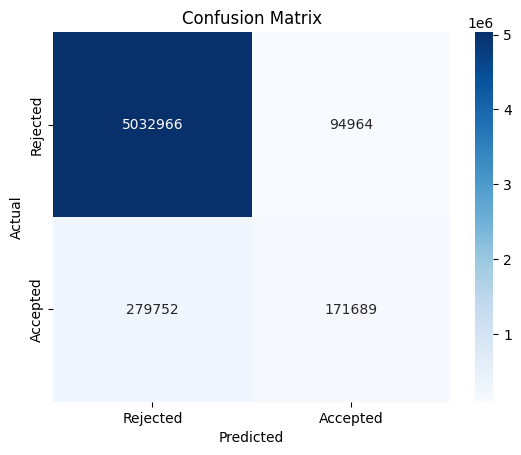

AUC: 0.8611349635763162


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert prediction results
predictions = model.transform(test_df)
preds_pd = predictions.select("accepted_flag", "prediction").toPandas()
print(classification_report(preds_pd["accepted_flag"], preds_pd["prediction"], target_names=["Rejected", "Accepted"]))

# Visualize Confusion Matrix
cm = confusion_matrix(preds_pd["accepted_flag"], preds_pd["prediction"])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Rejected", "Accepted"], yticklabels=["Rejected", "Accepted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# AUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="accepted_flag")
print("AUC:", evaluator.evaluate(predictions))

## Cap **dti** and **loan_amnt**
* Cap **dti** at 50

* Cap **loan_amnt** at 42,500

In [ ]:
recapped_df = combined_df.withColumn("dti_recapped", when(col("dti") > 50, 50).otherwise(col("dti"))) \
                       .withColumn("loan_amnt_recapped", when(col("loan_amnt") > 42500, 42500).otherwise(col("loan_amnt")))

In [ ]:
# Split data

retrain_df, retest_df = recapped_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Assemble capped features

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["loan_amnt_recapped", "dti_recapped", "emp_length_years"], outputCol="raw_features")
reassembled = assembler.transform(recapped_df)
reassembled.select("loan_amnt_recapped", "dti_recapped", "emp_length_years", "raw_features").show(5, truncate=False)

+------------------+------------+----------------+--------------------+
|loan_amnt_recapped|dti_recapped|emp_length_years|raw_features        |
+------------------+------------+----------------+--------------------+
|3600.0            |5.91        |10              |[3600.0,5.91,10.0]  |
|24700.0           |16.06       |10              |[24700.0,16.06,10.0]|
|20000.0           |10.78       |10              |[20000.0,10.78,10.0]|
|35000.0           |17.06       |10              |[35000.0,17.06,10.0]|
|10400.0           |25.37       |3               |[10400.0,25.37,3.0] |
+------------------+------------+----------------+--------------------+
only showing top 5 rows



In [ ]:
# Fit MinMax Scaler on 'raw_features'

from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="raw_features", outputCol="features")
scaler_model = scaler.fit(reassembled)
rescaled_df = scaler_model.transform(reassembled)
rescaled_df.select("loan_amnt_recapped", "dti_recapped", "emp_length_years", "features").show(5, truncate=False)

+------------------+------------+----------------+-----------------------------------------------------------+
|loan_amnt_recapped|dti_recapped|emp_length_years|features                                                   |
+------------------+------------+----------------+-----------------------------------------------------------+
|3600.0            |5.91        |10              |[0.08470588235294119,0.1182,1.0]                           |
|24700.0           |16.06       |10              |[0.5811764705882353,0.3212,1.0]                            |
|20000.0           |10.78       |10              |[0.4705882352941177,0.21559999999999999,1.0]               |
|35000.0           |17.06       |10              |[0.823529411764706,0.3412,1.0]                             |
|10400.0           |25.37       |3               |[0.2447058823529412,0.5074000000000001,0.36363636363636365]|
+------------------+------------+----------------+-----------------------------------------------------------+
o

In [ ]:
# Train model

from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Model
lr = LogisticRegression(featuresCol="features", labelCol="accepted_flag")

# Pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])
model = pipeline.fit(retrain_df)

AssertionError: 

# **EVALUATIONS**

### class_weight (1.0/1.0)

              precision    recall  f1-score   support

    Rejected       0.95      0.98      0.96   5127930
    Accepted       0.64      0.38      0.48    451441

    accuracy                           0.93   5579371
   macro avg       0.80      0.68      0.72   5579371
weighted avg       0.92      0.93      0.92   5579371



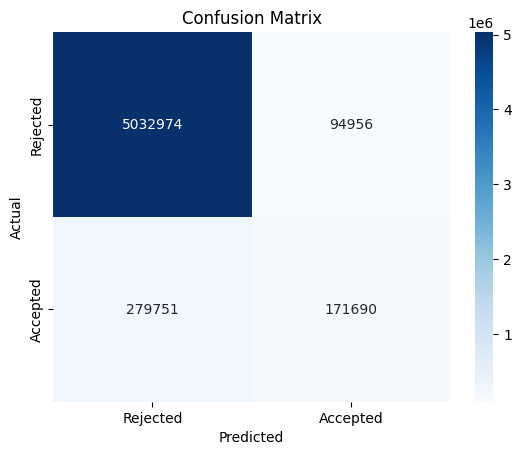

AUC: 0.861150685381594


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert prediction results
predictions = model.transform(retest_df)
preds_pd = predictions.select("accepted_flag", "prediction").toPandas()
print(classification_report(preds_pd["accepted_flag"], preds_pd["prediction"], target_names=["Rejected", "Accepted"]))

# Visualize Confusion Matrix
cm = confusion_matrix(preds_pd["accepted_flag"], preds_pd["prediction"])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Rejected", "Accepted"], yticklabels=["Rejected", "Accepted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# AUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="accepted_flag")
print("AUC:", evaluator.evaluate(predictions))

### class_weight (12.26/1.0)

              precision    recall  f1-score   support

    Rejected       0.97      0.88      0.93   5127930
    Accepted       0.35      0.73      0.47    451441

    accuracy                           0.87   5579371
   macro avg       0.66      0.80      0.70   5579371
weighted avg       0.92      0.87      0.89   5579371



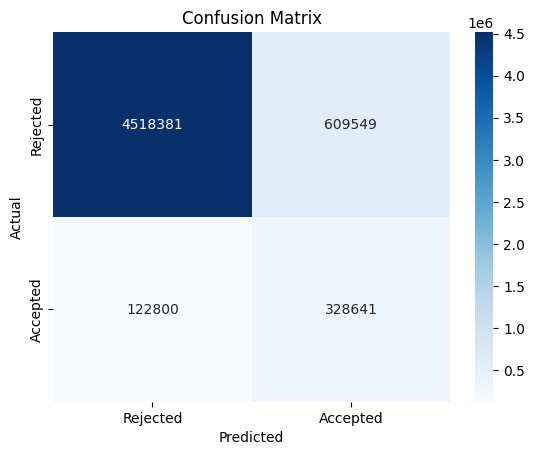

AUC: 0.8620388091895714


In [ ]:
recapped_df = combined_df.withColumn("dti_recapped", when(col("dti") > 50, 50).otherwise(col("dti"))) \
                         .withColumn("loan_amnt_recapped", when(col("loan_amnt") > 42500, 42500).otherwise(col("loan_amnt"))) \
                         .withColumn("class_weight", when(col('accepted_flag') == 1, 12.26).otherwise(1.0))

# Split data
retrain_df, retest_df = recapped_df.randomSplit([0.8, 0.2], seed=42)

# Assemble capped features
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=["loan_amnt_recapped", "dti_recapped", "emp_length_years", ], outputCol="raw_features")
reassembled = assembler.transform(recapped_df)
reassembled.select("loan_amnt_recapped", "dti_recapped", "emp_length_years", "raw_features")

# Fit MinMax Scaler on 'raw_features'
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler(inputCol="raw_features", outputCol="features")
scaler_model = scaler.fit(reassembled)
rescaled_df = scaler_model.transform(reassembled)
rescaled_df.select("loan_amnt_recapped", "dti_recapped", "emp_length_years", "features")

# Train the model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

lr = LogisticRegression(featuresCol="features", labelCol="accepted_flag", weightCol = "class_weight")
pipeline = Pipeline(stages=[assembler, scaler, lr])
model = pipeline.fit(retrain_df)

# Predictions & Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = model.transform(retest_df)
preds_pd = predictions.select("accepted_flag", "prediction").toPandas()
print(classification_report(preds_pd["accepted_flag"], preds_pd["prediction"], target_names=["Rejected", "Accepted"]))

# Visualize Confusion Matrix
cm = confusion_matrix(preds_pd["accepted_flag"], preds_pd["prediction"])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Rejected", "Accepted"], yticklabels=["Rejected", "Accepted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# AUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="accepted_flag")
print("AUC:", evaluator.evaluate(predictions))

## **FEATURE IMPORTANCE**

### Coefficients

In [ ]:
feature_cols = ["loan_amnt_capped", "dti_capped", "emp_length_years"]

lr_model = model.stages[-1]

coeffs = lr_model.coefficients.toArray()

coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": coeffs
})
coef_df["abs_coefficient"] = np.abs(coef_df["coefficient"])
coef_df_sorted = coef_df.sort_values("abs_coefficient", ascending=False)
coef_df_sorted

,feature,coefficient,abs_coefficient
2,emp_length_years,4.600914,4.600914
1,dti_capped,-0.821242,0.821242
0,loan_amnt_capped,0.784724,0.784724


#### Positive loan_amnt coefficient

In [ ]:
loan_bucketed = rescaled_df.withColumn(
    "loan_amnt_bucket",
    when(col("loan_amnt_capped") < 5000, "0–5K")
    .when((col("loan_amnt_capped") >= 5000) & (col("loan_amnt_capped") < 10000), "5–10K")
    .when((col("loan_amnt_capped") >= 10000) & (col("loan_amnt_capped") < 20000), "10–20K")
    .when((col("loan_amnt_capped") >= 20000) & (col("loan_amnt_capped") < 30000), "20–30K")
    .when((col("loan_amnt_capped") >= 30000) & (col("loan_amnt_capped") < 40000), "30–40K")
    .when((col("loan_amnt_capped") >= 40000) & (col("loan_amnt_capped") < 50000), "40–50K")
    .when((col("loan_amnt_capped") >= 50000) & (col("loan_amnt_capped") < 60000), "50–60K")
    .otherwise("60K+")
)


acceptance_by_bucket = loan_bucketed.groupBy("loan_amnt_bucket", "accepted_flag") \
    .agg(count("*").alias("count")) \
    .groupBy("loan_amnt_bucket") \
    .pivot("accepted_flag", [0, 1]) \
    .sum("count") \
    .fillna(0) \
    .withColumnRenamed("0", "rejected") \
    .withColumnRenamed("1", "accepted")


from pyspark.sql.functions import round

acceptance_by_bucket = acceptance_by_bucket.withColumn(
    "acceptance_rate",
    round(col("accepted") / (col("accepted") + col("rejected")) * 100, 2)
).orderBy(col('acceptance_rate').desc()).toPandas()

acceptance_by_bucket

,loan_amnt_bucket,rejected,accepted,acceptance_rate
0,20–30K,3478274,435221,11.12
1,10–20K,7142919,881155,10.98
2,5–10K,5534798,494884,8.21
3,30–40K,2239037,197761,8.12
4,40–50K,812566,33029,3.91
5,0–5K,6430113,214344,3.23
